**Introduction**

* This kernel is a detailed guide for transfer learning on Dog Breeds problem, it's all about learning a new technique, evaluate it using only Kaggle training set without cheating.

* The aim of this kernel is to show you how to use pre-trained CNN models as feature extractors, which one of the most effective transfer learning techniques.

* A reasonable question comes to your mind, 'Wait, why do we have to use this technique, why don't we just use regular transfer learning ?', if you try to do so, you will figure out that the problem is pretty hard for a single model to handle (you would get higher loss and less accuracy).

* It's even hard for humankind to distinguish between 120 dog breeds!, single poor CNN would struggle.

**Explanation**

* Take look at general CNN architecture for image classification in two main parts, “feature extractor” that based on conv-layers, and “classifier” which usually based on fully connected layers:

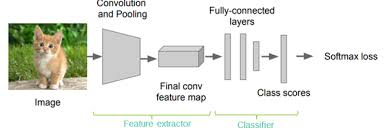

* Simply, feature extractor could be created as follow > (Feature Extractor = Pretrained Model - Late Fully Connected Layers)

* For example, InceptionV3 feature extractor (without last FC layer) outputs 2048 vector for each image sample, each value represent a certain feature of dog image (Coded in numerical values of course), like Dog color?, How big is his head?, Shape of the eyes?, length of the tale?, Size? .. etc

* Hence, more "different" feature extractors mean more features to be used to determine which breed does this dog belong.

* So our strategy goes as the following,
  1. Create 4 feature extractor using different pre-trained CNN models
  2. Extract features from raw data and stacks the features together.
  3. Use a simple DNN with one dense layer and a heavy dropout layer to figure out patterns in the feature extracted from the data.
     
     
* The code is simple, concise and fully-commented. Feel free to ask for help / more info / more explanation in the comments.

* Finally if this kernel helps you somehow, kindly don't forget to leave a little upvote.

* ENJOY.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2, random, time, shutil, csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
np.random.seed(42)
%matplotlib inline 

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
def get_num_files(path):
    '''
    Counts the number of files in a folder.
    '''
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

In [ ]:
#Data Paths
train_dir = '/kaggle/input/dog-breed-identification/train'
test_dir = '/kaggle/input/dog-breed-identification/test'
#Count/Print train and test samples.
data_size = get_num_files(train_dir)
test_size = get_num_files(test_dir)
print('Data samples size: ', data_size)
print('Test samples size: ', test_size)

In [ ]:
#Read train labels.
labels_dataframe = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
#Read sample_submission file to be modified by pridected labels.
sample_df = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')
#Incpect labels_dataframe.
labels_dataframe.head(5)

In [ ]:
#Create list of alphabetically sorted labels.
dog_breeds = sorted(list(set(labels_dataframe['breed'])))
n_classes = len(dog_breeds)
print(n_classes)
dog_breeds[:10]

In [ ]:
#Map each label string to an integer label.
class_to_num = dict(zip(dog_breeds, range(n_classes)))

In [ ]:
def images_to_array(data_dir, labels_dataframe, img_size = (224,224,3)):
    '''
    1- Read image samples from certain directory.
    2- Risize it, then stack them into one big numpy array.
    3- Read sample's label form the labels dataframe.
    4- One hot encode labels array.
    5- Shuffle Data and label arrays.
    '''
    images_names = labels_dataframe['id']
    images_labels = labels_dataframe['breed']
    data_size = len(images_names)
    #initailize output arrays.
    X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
    y = np.zeros([data_size,1], dtype=np.uint8)
    #read data and lables.
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        img_pixels = load_img(img_dir, target_size=img_size)
        X[i] = img_pixels
        
        image_breed = images_labels[i]
        y[i] = class_to_num[image_breed]
    
    #One hot encoder
    y = to_categorical(y)
    #shuffle    
    ind = np.random.permutation(data_size)
    X = X[ind]
    y = y[ind]
    print('Ouptut Data Size: ', X.shape)
    print('Ouptut Label Size: ', y.shape)
    return X, y

In [ ]:
#img_size chosen to be 331 to suit the used architectures.
img_size = (331,331,3)
X, y = images_to_array(train_dir, labels_dataframe, img_size)

In [ ]:
def get_features(model_name, data_preprocessor, input_size, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [ ]:
# Extract features using InceptionV3 as extractor.
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

In [ ]:
# Extract features using Xception as extractor.
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

In [ ]:
# Extract features using NASNetLarge as extractor.
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

In [ ]:
# Extract features using InceptionResNetV2 as extractor.
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

In [ ]:
#It's a good habit to free up some RAM memory.
#X variable won't be needed anymore, so let's get rid of it.
del X

In [ ]:
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1)
print('Final feature maps shape', final_features.shape)

In [ ]:
from keras.callbacks import EarlyStopping
#Prepare call backs
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

In [ ]:
#Prepare DNN model
dnn = keras.models.Sequential([
    InputLayer(final_features.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation='softmax')
])

dnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Train simple DNN on extracted features.
h = dnn.fit(final_features, y,
            batch_size=128,
            epochs=60,
            validation_split=0.1,
            callbacks=my_callback)

In [ ]:
def images_to_array2(data_dir, labels_dataframe, img_size = (224,224,3)):
    '''
    Do same as images_to_array but omit some unnecessary steps for test data.
    '''
    images_names = labels_dataframe['id']
    data_size = len(images_names)
    X = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        img_pixels = tf.keras.preprocessing.image.load_img(img_dir, target_size=img_size)
        X[i] = img_pixels
        
    print('Ouptut Data Size: ', X.shape)
    return X

test_data = images_to_array2(test_dir, sample_df, img_size)

In [ ]:
#Extract test data features.
inception_features = get_features(InceptionV3, inception_preprocessor, img_size, test_data)
xception_features = get_features(Xception, xception_preprocessor, img_size, test_data)
nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, test_data)
inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, test_data)

test_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features],axis=-1)
print('Final feature maps shape', test_features.shape)

In [ ]:
#Free up some space.
del test_data

In [ ]:
#Predict test labels given test data features.
y_pred = dnn.predict(test_features, batch_size=128)

In [ ]:
#Create submission file
for b in dog_breeds:
    sample_df[b] = y_pred[:,class_to_num[b]]
sample_df.to_csv('pred.csv', index=None)

Inspired by: [https://www.kaggle.com/c/dog-breed-identification/discussion/40779](http://)